In [1]:
#notebook to create a table of sky subtraction quality metrics from an RSS file of sky subtracted spectra

In [16]:
#need to read in an RSS file, get flux, sky, ivar, wave
#for sky lines, can sum over flux in sky, then flux in flux (sky sub) to find frac that was removed
#measure cont
#for science lines areas, could fit gaussians to sky lines in sky, use as template to see how much sky was removed
#for science lines aread, come up with a way to convert sky line residual into an uncertainty on the sci line
#relate sky line residual with ivar (assuming ivar is correct)
#knox's method which says, flux-sky line residual flux in the shape of the sky (after background removal), frac error- flux/skyflux
#any other metrics for now?
#faintness limit for detecting science line
#sky line and cont metrics can be same lines/areas as before (no need to change at this point)
#then need to save all metrics per spectrum in a nice table

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits, ascii
from astropy.table import Table,vstack
from scipy.optimize import bisect
from astropy.stats import sigma_clip
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord
import astropy.units as u

Science lines affected by sky:
    [OI] 6300, 6363 Å – tracers of shocks and ionization fronts

    [NI] 5198, 5200 Å – also tracers of shocks and ionization fronts; useful for density diagnostics and continuum fluorescence

    [OII] 7320, 7330 Å – auroral lines sensitive to electron temperature

    HeI 7281 Å – singlet line sensitive to deviations from Case B and to temperature

    HI 8863, 9015, 9229, 9545 Å – Paschen lines useful for reddening maps

    [SIII] 9069, 9531 Å – critical for determining temperature and S++ abundance

    [Cl II] 9123 Å – ionic abundance of Cl+

    [Cl IV] 8045 Å – ionic abundance of Cl³⁺

    [FeII] 8617 Å – ionic abundance of Fe⁺

    [CI] 8727 Å – recombination/auroral line of neutral carbon

In [14]:
#RSS file input, using old summary file as example
with fits.open('XSframe_4000_30000_1.fits') as hdul:
    wave=hdul['WAVE'].data
    flux=hdul['FLUX'].data
    sky=hdul['SKY'].data
    ivar=hdul['ivar'].data

(-1e-13, 5e-13)

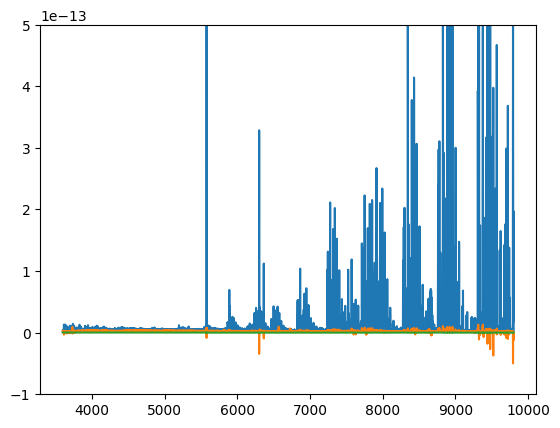

In [15]:
#test plots to make sure wave, sky, flux, and ivar look ok
plt.plot(wave,sky[100])
plt.plot(wave,flux[100])
plt.plot(wave,1/np.sqrt(ivar[100]))
plt.ylim(-0.1e-12,0.5e-12)

In [19]:
#names of sky lines and cont regions
sky_list=['[OI]5577', '[OI]6300', '[OH]6865', '[Na]5891', 'O2', 'AirglowCont', 'Bcont', 'Rcont', 'Zcont']
#wave locations of the sky line or region
lrangelist=[(5574, 5580), (6298,6304), (6862,6868), (5888, 5898), (8630, 8670), (5420, 5440), (4195, 4220), (6420, 6440), (9130, 9145)]
#extened range around the line for background cont subtraction where -999 means no cont subtraction done
crangelist=[(5571, 5583), (6295, 6307), (6859, 6871), (5885, 5901), (-999, -999), (-999, -999), (-999, -999), (-999, -999), (-999, -999)]
#names of the science lines of interest
sci_lines=['[NI]5198','[NI]5200','[OII]7320','[OII]7330','HeI7281','HI8863','HI9015','HI9229','HI9545','[SIII]9069','[SIII]9531','[ClII]9123','[ClIV]8045','[FeII]8617','[CI]8727']
#wave location of those science lines
sci_lines_wave=[5198, 5200, 7320, 7330, 7281, 8863, 9015, 9229, 9545, 9069, 9531, 9123, 8045, 8617, 8727]
#OH and O2 should check wavelengths

In [30]:
#calculate sky line residual flux and sky line residual flux over sky line flux
#sky line residual flux over error
#for a single median exposure

#loops over all the sky lines/regions to get metrics for a given flux, sky, ivar
def sky_line_metrics(wave, flux, sky, ivar, sky_line_list, lrangelist, crangelist):
    resid_mean_list = [] #mean flux of the sky line residual
    resid_med_list = [] #median flux of the sky line residual
    resid_std_list = [] #standard deviation of the sky line residual
    sky_mean_list = [] #mean of the sky flux (before sky subtraction)
    sky_med_list = [] #median of sky flux (before sky subtraction)
    sky_std_list = [] #standard deviation of sky flux (before sky subtraction)
    error_med_list = [] #median of the error after sky subtraction
    resid_sky_list = [] #residual flux over sky flux (like Knox's frac_error)
    resid_error_list = [] #residual flux over error

    for j in range(len(sky_list)):
        wvl, wvc = line_windows(lrangelist[j], crangelist[j], wave)
        resid_mean, resid_med, resid_std, sky_mean, sky_med, sky_std, error_med, resid_sky, resid_error = line_stats(flux, sky, ivar, wvl, wvc)
        resid_mean_list.append(resid_mean)
        resid_med_list.append(resid_med)
        resid_std_list.append(resid_std)
        sky_mean_list.append(sky_mean)
        sky_med_list.append(sky_med)
        sky_std_list.append(sky_std)
        error_med_list.append(error_med)
        resid_sky_list.append(resid_sky)
        resid_error_list.append(resid_error)
    
    return resid_mean_list, resid_med_list, resid_std_list, sky_mean_list, sky_med_list, sky_std_list, error_med_list, resid_sky_list, resid_error_list

#converts lrange and crange into wavelengths for each
def line_windows(lrange, crange, wave):
    wave_line = (wave>=lrange[0]) & (wave<=lrange[1]) # line range selection
    #ignores cont if crange is -999, and sets to -999
    if crange[0] == -999:
        wave_cont = [-999]
    else:
        wave_cont = ((wave>=crange[0]) & (wave<lrange[0])) | ((wave>lrange[1]) & (wave<=crange[1])) # cont range selection
    return wave_line, wave_cont

#calculates the sky line/region metrics
def line_stats(flux, sky, ivar, wave_line, wave_cont):
    #subtracting the average background cont if not -999
    if wave_cont[0] == -999:
        norm_line_flux = flux[wave_line]
        norm_line_sky = sky[wave_line]
    else:
        norm_line_flux = flux[wave_line]-np.nanmedian(flux[wave_cont])
        norm_line_sky = sky[wave_line]-np.nanmedian(sky[wave_cont])
        
    #rel_line_flux = norm_line_flux * np.sqrt(ivar[wave_line])
    resid_mean = np.nanmean(norm_line_flux)
    resid_med = np.nanmedian(norm_line_flux)
    resid_std = np.nanstd(norm_line_flux)
    sky_mean = np.nanmean(norm_line_sky) #for the sky fluxes, should these be sums? for regions its ok, but for lines??
    sky_med = np.nanmedian(norm_line_sky)
    sky_std = np.nanstd(norm_line_sky)
    error_med = np.nanmedian(1./np.sqrt(ivar[wave_line]))
    resid_sky = resid_med / sky_med #should this be done per pixel?
    resid_error = resid_med / error_med
    return resid_mean, resid_med, resid_std, sky_mean, sky_med, sky_std, error_med, resid_sky, resid_error

In [26]:
resid_mean_list, resid_med_list, resid_std_list, sky_mean_list, sky_med_list, sky_std_list, error_med_list, resid_sky_list, resid_error_list = sky_line_metrics(wave, flux[100], sky[100], ivar[100], sky_list, lrangelist, crangelist)

In [31]:
#testing if the line stats work, and looks ok!
for j in range(len(sky_list)):
    print(sky_list[j], resid_med_list[j], sky_med_list[j], error_med_list[j], resid_sky_list[j], resid_error_list[j])

[OI]5577 6.5041246e-16 1.862241e-14 1.2451866e-16 0.03492633 5.2234135
[OI]6300 -3.1077406e-16 1.1191758e-14 8.234663e-17 -0.027768118 -3.7739742
[OH]6865 7.8347287e-16 7.751519e-15 6.9457324e-17 0.101073466 11.279918
[Na]5891 2.2688857e-16 1.4033523e-14 9.202014e-17 0.016167613 2.4656405
O2 1.5512032e-15 3.2033973e-14 7.3645094e-17 0.048423693 21.063225
AirglowCont 2.739477e-15 5.1675096e-15 7.619435e-17 0.53013486 35.953804
Bcont 2.9125872e-15 5.3573517e-15 1.0734302e-16 0.5436618 27.133455
Rcont 2.4590548e-15 4.659005e-15 5.1802057e-17 0.5278068 47.470215
Zcont 1.7049556e-15 3.7712766e-15 3.8416087e-17 0.4520898 44.38129


In [34]:
#set of metrics to determine sky sub quality at a given sci line wave
#per single median expsoure (one wave, flux, sky, and ivar)
#average sky line residuals flux and std
#sky line residuals over sky flux
#sky line residuals are only useful when looking at sky sub of sky spectra or known source

#more sophistcated approach would be to find where sky flux is in sky and see how well those pixels are subtracted, in these regions I am assuming there will be multiple sky lines present
def science_line_metrics(wave, flux, sky, ivar, sci_lines_wave):
    
    resid_mean_list = [] #mean flux of the sky line residual
    resid_med_list = [] #median flux of the sky line residual
    resid_std_list = [] #standard deviation of the sky line residual
    sky_mean_list = [] #mean of the sky flux (before sky subtraction)
    sky_med_list = [] #median of sky flux (before sky subtraction)
    sky_std_list = [] #standard deviation of sky flux (before sky subtraction)
    error_med_list = [] #median of the error after sky subtraction
    resid_sky_list = [] #residual flux over sky flux (like Knox's frac_error)
    resid_error_list = [] #residual flux over error
    sum_sky_flux_list = [] #total flux from sky before sky subtraction in flagged sky pixels
    sum_skyresid_flux_list = [] #totol flux in residuals after sky subtraction in flagged sky pixels
    skyresid_sky_list = [] #ratio of total flux in residuals over sky from flagged sky pixels

    for j in range(len(sci_lines_wave)):
        wave_region = (wave>=sci_lines_wave[j]-3) & (wave<=sci_lines_wave[j]+3) #defining a 6Ang wide region centered on sci line
        #getting same stats as for the sky lines, but now for the sci lines and no background sub since its region
        resid_mean, resid_med, resid_std, sky_mean, sky_med, sky_std, error_med, resid_sky, resid_error = line_stats(flux, sky, ivar, wave_region, [-999])
        resid_mean_list.append(resid_mean)
        resid_med_list.append(resid_med)
        resid_std_list.append(resid_std)
        sky_mean_list.append(sky_mean)
        sky_med_list.append(sky_med)
        sky_std_list.append(sky_std)
        error_med_list.append(error_med)
        resid_sky_list.append(resid_sky)
        resid_error_list.append(resid_error)
        #getting stats of the more sophisticated approach
        sum_sky_flux, sum_skyresid_flux, skyresid_sky = sci_region_stats(wave_region, flux, sky)
        sum_sky_flux_list.append(sum_sky_flux)
        sum_skyresid_flux_list.append(sum_skyresid_flux)
        skyresid_sky_list.append(skyresid_sky)
        
    
    return resid_mean_list, resid_med_list, resid_std_list, sky_mean_list, sky_med_list, sky_std_list, error_med_list, resid_sky_list, resid_error_list, sum_sky_flux_list, sum_skyresid_flux_list, skyresid_sky_list


def find_sky(wave_region, sky):
    background = np.nanpercentile(abs(sky[wave_region]),10) #doing abs() in case of absorption features
    wave_sky = sky[wave_region] > background #should flag all sky emission in region
    return wave_sky
    
def sci_region_stats (wave_region, flux, sky):
    wave_sky = find_sky(wave_region, sky)
    sum_sky_flux = np.sum(sky[wave_region][wave_sky]) #total flux from sky before sky subtraction
    sum_skyresid_flux = np.sum(flux[wave_region][wave_sky]) #total flux from sky residuals (after sky subtraction)
    skyresid_sky = sum_skyresid_flux / sum_sky_flux #ratio of the residuals over sky in flagged sky pixels
    return sum_sky_flux, sum_skyresid_flux, skyresid_sky

In [35]:
resid_mean_sci, resid_med_sci, resid_std_sci, sky_mean_sci, sky_med_sci, sky_std_sci, error_med_sci, resid_sky_sci, resid_error_sci, sum_sky_flux_sci, sum_skyresid_flux_sci, skyresid_sky_sci = science_line_metrics(wave, flux[100], sky[100], ivar[100], sci_lines_wave)

In [36]:
#testing if the line stats work, and looks ok!
for j in range(len(sci_lines)):
    print(sci_lines[j], resid_med_sci[j], sky_med_sci[j], error_med_sci[j], resid_sky_sci[j], resid_error_sci[j], sum_sky_flux_sci[j], sum_skyresid_flux_sci[j], skyresid_sky_sci[j])

[NI]5198 2.7165524e-15 8.77222e-15 8.880831e-17 0.30967674 30.588945 9.6761805e-14 2.847482e-14 0.29427746
[NI]5200 2.7165524e-15 8.77222e-15 8.880831e-17 0.30967674 30.588945 1.0100941e-13 2.9489293e-14 0.291946
[OII]7320 2.2920394e-15 4.1657313e-15 5.1560917e-17 0.550213 44.453037 1.4199079e-13 3.0116246e-14 0.2121
[OII]7330 2.2317457e-15 7.0379773e-15 5.6441266e-17 0.31710044 39.541027 2.7831635e-13 2.6337417e-14 0.094631225
HeI7281 2.4481374e-15 8.0464945e-15 6.248521e-17 0.30424893 39.17947 1.6792587e-13 3.067156e-14 0.18264942
HI8863 1.7810085e-15 1.0358739e-14 4.9101365e-17 0.17193295 36.27208 1.354691e-13 1.9111272e-14 0.14107478
HI9015 1.7435991e-15 2.9611582e-15 3.6732507e-17 0.5888234 47.46747 3.3174608e-14 1.9391357e-14 0.5845241
HI9229 1.6501897e-15 5.3141212e-15 4.45855e-17 0.31052917 37.0118 7.476461e-14 1.7859083e-14 0.23887081
HI9545 1.3374189e-15 2.8799154e-15 4.869962e-17 0.4643952 27.462614 3.35209e-14 1.437746e-14 0.42891032
[SIII]9069 1.6415075e-15 7.97625e-15 4.7

In [37]:
#need to loop over all median spectra/expnums and print to nice table...

In [51]:
def run_one_expnum(wave, flux, sky, ivar, sky_list, lrangelist, crangelist, sci_lines, sci_lines_wave):
    
    resid_mean_list, resid_med_list, resid_std_list, sky_mean_list, sky_med_list, sky_std_list, error_med_list, resid_sky_list, resid_error_list = sky_line_metrics(wave, flux, sky, ivar, sky_list, lrangelist, crangelist)
    resid_mean_sci, resid_med_sci, resid_std_sci, sky_mean_sci, sky_med_sci, sky_std_sci, error_med_sci, resid_sky_sci, resid_error_sci, sum_sky_flux_sci, sum_skyresid_flux_sci, skyresid_sky_sci = science_line_metrics(wave, flux, sky, ivar, sci_lines_wave)

    row = []
    for j in range(len(sky_list)):
        row.append(resid_mean_list[j])
        row.append(resid_med_list[j])
        row.append(resid_std_list[j])
        row.append(sky_mean_list[j])
        row.append(sky_med_list[j])
        row.append(sky_std_list[j]) 
        row.append(error_med_list[j])
        row.append(resid_sky_list[j])
        row.append(resid_error_list[j])
    for j in range(len(sci_lines)):
        row.append(resid_mean_sci[j])
        row.append(resid_med_sci[j])
        row.append(resid_std_sci[j])
        row.append(sky_mean_sci[j])
        row.append(sky_med_sci[j])
        row.append(sky_std_sci[j]) 
        row.append(error_med_sci[j])
        row.append(resid_sky_sci[j])
        row.append(resid_error_sci[j])
        row.append(sum_sky_flux_sci[j])
        row.append(sum_skyresid_flux_sci[j])
        row.append(skyresid_sky_sci[j])

    return row

def run_RSS(wave, flux, sky, ivar, sky_list, lrangelist, crangelist, sci_lines, sci_lines_wave):

    column_names = []
    for j in range(len(sky_list)):
        column_names.append(f"{sky_list[j]}_resid_mean")
        column_names.append(f"{sky_list[j]}_resid_med")
        column_names.append(f"{sky_list[j]}_resid_std")
        column_names.append(f"{sky_list[j]}_sky_mean")
        column_names.append(f"{sky_list[j]}_sky_med")
        column_names.append(f"{sky_list[j]}_sky_std") 
        column_names.append(f"{sky_list[j]}_error_med")
        column_names.append(f"{sky_list[j]}_resid_sky")
        column_names.append(f"{sky_list[j]}_resid_error")
    for j in range(len(sci_lines)):
        column_names.append(f"{sci_lines[j]}_resid_mean")
        column_names.append(f"{sci_lines[j]}_resid_med")
        column_names.append(f"{sci_lines[j]}_resid_std")
        column_names.append(f"{sci_lines[j]}_sky_mean")
        column_names.append(f"{sci_lines[j]}_sky_med")
        column_names.append(f"{sci_lines[j]}_sky_std") 
        column_names.append(f"{sci_lines[j]}_error_med")
        column_names.append(f"{sci_lines[j]}_resid_sky")
        column_names.append(f"{sci_lines[j]}_resid_error")
        column_names.append(f"{sci_lines[j]}_sum_sky_flux")
        column_names.append(f"{sci_lines[j]}_sum_skyresid_flux")
        column_names.append(f"{sci_lines[j]}_skyresid_sky")

    metrics_tab = Table(names=column_names)

    #here loop over all expnums
    for i in range(flux.shape[0]):
        new_row = run_one_expnum(wave, flux[i], sky[i], ivar[i], sky_list, lrangelist, crangelist, sci_lines, sci_lines_wave)
        metrics_tab.add_row(new_row)

    return metrics_tab

In [52]:
tab=run_RSS(wave, flux, sky, ivar, sky_list, lrangelist, crangelist, sci_lines, sci_lines_wave)

/var/folders/bm/c8rp0vhj60b1sv88fgj8p_700002hd/T/ipykernel_24875/2940138764.py:55: RuntimeWarning: invalid value encountered in scalar divide
  skyresid_sky = sum_skyresid_flux / sum_sky_flux #ratio of the residuals over sky in flagged sky pixels


In [53]:
tab

[OI]5577_resid_mean,[OI]5577_resid_med,[OI]5577_resid_std,[OI]5577_sky_mean,[OI]5577_sky_med,[OI]5577_sky_std,[OI]5577_error_med,[OI]5577_resid_sky,[OI]5577_resid_error,[OI]6300_resid_mean,[OI]6300_resid_med,[OI]6300_resid_std,[OI]6300_sky_mean,[OI]6300_sky_med,[OI]6300_sky_std,[OI]6300_error_med,[OI]6300_resid_sky,[OI]6300_resid_error,[OH]6865_resid_mean,[OH]6865_resid_med,[OH]6865_resid_std,[OH]6865_sky_mean,[OH]6865_sky_med,[OH]6865_sky_std,[OH]6865_error_med,[OH]6865_resid_sky,[OH]6865_resid_error,[Na]5891_resid_mean,[Na]5891_resid_med,[Na]5891_resid_std,[Na]5891_sky_mean,[Na]5891_sky_med,[Na]5891_sky_std,[Na]5891_error_med,[Na]5891_resid_sky,[Na]5891_resid_error,O2_resid_mean,O2_resid_med,O2_resid_std,O2_sky_mean,O2_sky_med,O2_sky_std,O2_error_med,O2_resid_sky,O2_resid_error,AirglowCont_resid_mean,AirglowCont_resid_med,AirglowCont_resid_std,AirglowCont_sky_mean,AirglowCont_sky_med,AirglowCont_sky_std,AirglowCont_error_med,AirglowCont_resid_sky,AirglowCont_resid_error,Bcont_resid_mean,Bcont_resid_med,Bcont_resid_std,Bcont_sky_mean,Bcont_sky_med,Bcont_sky_std,Bcont_error_med,Bcont_resid_sky,Bcont_resid_error,Rcont_resid_mean,Rcont_resid_med,Rcont_resid_std,Rcont_sky_mean,Rcont_sky_med,Rcont_sky_std,Rcont_error_med,Rcont_resid_sky,Rcont_resid_error,Zcont_resid_mean,Zcont_resid_med,Zcont_resid_std,Zcont_sky_mean,Zcont_sky_med,Zcont_sky_std,Zcont_error_med,Zcont_resid_sky,Zcont_resid_error,[NI]5198_resid_mean,[NI]5198_resid_med,[NI]5198_resid_std,[NI]5198_sky_mean,[NI]5198_sky_med,[NI]5198_sky_std,[NI]5198_error_med,[NI]5198_resid_sky,[NI]5198_resid_error,[NI]5198_sum_sky_flux,[NI]5198_sum_skyresid_flux,[NI]5198_skyresid_sky,[NI]5200_resid_mean,[NI]5200_resid_med,[NI]5200_resid_std,[NI]5200_sky_mean,[NI]5200_sky_med,[NI]5200_sky_std,[NI]5200_error_med,[NI]5200_resid_sky,[NI]5200_resid_error,[NI]5200_sum_sky_flux,[NI]5200_sum_skyresid_flux,[NI]5200_skyresid_sky,[OII]7320_resid_mean,[OII]7320_resid_med,[OII]7320_resid_std,[OII]7320_sky_mean,[OII]7320_sky_med,[OII]7320_sky_std,[OII]7320_error_med,[OII]7320_resid_sky,[OII]7320_resid_error,[OII]7320_sum_sky_flux,[OII]7320_sum_skyresid_flux,[OII]7320_skyresid_sky,[OII]7330_resid_mean,[OII]7330_resid_med,[OII]7330_resid_std,[OII]7330_sky_mean,[OII]7330_sky_med,[OII]7330_sky_std,[OII]7330_error_med,[OII]7330_resid_sky,[OII]7330_resid_error,[OII]7330_sum_sky_flux,[OII]7330_sum_skyresid_flux,[OII]7330_skyresid_sky,HeI7281_resid_mean,HeI7281_resid_med,HeI7281_resid_std,HeI7281_sky_mean,HeI7281_sky_med,HeI7281_sky_std,HeI7281_error_med,HeI7281_resid_sky,HeI7281_resid_error,HeI7281_sum_sky_flux,HeI7281_sum_skyresid_flux,HeI7281_skyresid_sky,HI8863_resid_mean,HI8863_resid_med,HI8863_resid_std,HI8863_sky_mean,HI8863_sky_med,HI8863_sky_std,HI8863_error_med,HI8863_resid_sky,HI8863_resid_error,HI8863_sum_sky_flux,HI8863_sum_skyresid_flux,HI8863_skyresid_sky,HI9015_resid_mean,HI9015_resid_med,HI9015_resid_std,HI9015_sky_mean,HI9015_sky_med,HI9015_sky_std,HI9015_error_med,HI9015_resid_sky,HI9015_resid_error,HI9015_sum_sky_flux,HI9015_sum_skyresid_flux,HI9015_skyresid_sky,HI9229_resid_mean,HI9229_resid_med,HI9229_resid_std,HI9229_sky_mean,HI9229_sky_med,HI9229_sky_std,HI9229_error_med,HI9229_resid_sky,HI9229_resid_error,HI9229_sum_sky_flux,HI9229_sum_skyresid_flux,HI9229_skyresid_sky,HI9545_resid_mean,HI9545_resid_med,HI9545_resid_std,HI9545_sky_mean,HI9545_sky_med,HI9545_sky_std,HI9545_error_med,HI9545_resid_sky,HI9545_resid_error,HI9545_sum_sky_flux,HI9545_sum_skyresid_flux,HI9545_skyresid_sky,[SIII]9069_resid_mean,[SIII]9069_resid_med,[SIII]9069_resid_std,[SIII]9069_sky_mean,[SIII]9069_sky_med,[SIII]9069_sky_std,[SIII]9069_error_med,[SIII]9069_resid_sky,[SIII]9069_resid_error,[SIII]9069_sum_sky_flux,[SIII]9069_sum_skyresid_flux,[SIII]9069_skyresid_sky,[SIII]9531_resid_mean,[SIII]9531_resid_med,[SIII]9531_resid_std,[SIII]9531_sky_mean,[SIII]9531_sky_med,[SIII]9531_sky_std,[SIII]9531_error_med,[SIII]9531_resid_sky,[SIII]9531_resid_error,[SIII]9531_sum_sky_flux,[SIII]9531_sum_skyresid_flux,[SIII]9

In [54]:
ascii.write(tab, 'skysub_metrics.dat', overwrite=True, format='fixed_width')